In [1]:
from collections import defaultdict
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from scipy import stats
from config import config_dict
import glob
import h5py
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')
pd.options.display.max_columns=200
pd.options.display.max_rows=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/3'):
    os.makedirs('figs/3')

# Load data on shanks and lfp features of recordings with position

In [3]:
# Determine sessions with behavior
behavior_files = glob.glob('/gh/data2/hc3/behavior/*')
sess_behavior = [p[-13:-4] for p in behavior_files]
Fs_lfp = 1252

# Load shanks
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

In [4]:
df_shanks.head()

,index,rat,sess,sh,Fs,elec,burst_type,amp_mean,period_mean,rdsym_mean,ptsym_mean,cycling_frac,N_cycles_all,N_cycles_burst,N_seconds,corr_volt_amp_period_r,corr_volt_amp_period_p,corr_volt_amp_time_rdsym_r,corr_volt_amp_time_rdsym_p,corr_volt_amp_time_ptsym_r,corr_volt_amp_time_ptsym_p,corr_period_time_rdsym_r,corr_period_time_rdsym_p,corr_period_time_ptsym_r,corr_period_time_ptsym_p,corr_time_rdsym_time_ptsym_r,corr_time_rdsym_time_ptsym_p,mv_amp_mean,ms_period_mean
0,0,ec013,ec013.426,4,1250,0,0,2319.532520,161.287866,0.412290,0.414131,0.785563,11644,9362,1537.7272,-0.077456,6.156500e-14,0.040812,7.814688e-05,-0.056677,4.075107e-08,-0.078357,3.143550e-14,0.068883,2.523349e-11,-0.069632,1.533282e-11,2.319533,129.030293
1,4,ec013,ec013.426,5,1250,0,0,2200.710141,161.099577,0.412755,0.419072,0.773503,11619,9229,1537.7200,-0.068670,4.006313e-11,0.062534,1.825662e-09,-0.043223,3.271105e-05,-0.082509,2.039848e-15,0.070847,9.510113e-12,-0.067264,9.909330e-11,2.200710,128.879662
2,8,ec013,ec013.426,6,1250,0,0,1672.178699,161.369480,0.411551,0.448304,0.809731,11680,9646,1537.8640,0.018115,7.523005e-02,0.034804,6.287863e-04,-0.031303,2.106493e-03,-0.010428,3.058098e-01,0.058119,1.115245e-08,-0.090853,3.877569e-19,1.672179,129.095584
3,12,ec013,ec013.426,7,1250,0,0,1693.289664,161.321549,0.415398,0.475218,0.819043,11706,9759,1537.7336,0.010477,3.007297e-01,-0.052982,1.632134e-07,0.057119,1.636914e-08,0.045350,7.401943e-06,0.090220,4.271117e-19,-0.125847,9.571640e-36,1.693290,129.057239
4,16,ec013,ec013.482,4,1250,0,0,1919.829110,166.277068,0.403384,0.438942,0.803501,15953,13069,2163.6064,-0.008160,3.509288e-01,0.024827,4.534006e-03,-0.048778,2.418237e-08,-0.025403,3.680641e-03,0.057749,3.929036e-11,-0.051819,3.078324e-09,1.919829,133.021654


In [5]:
# For each session with behavior, load that movement df
dfs_behavior = []
dfs_sess = []
dfs_sh = []
for sess in sess_behavior:
    df_temp = df_shanks[df_shanks['sess']==sess]
    for i, row in df_temp.iterrows():
        # Load df
        base_path = config_dict['mat_path'] + '/' + row['rat'] + '/' + row['sess'] + '/' + str(row['sh']) + '/'
        df = pd.read_csv(base_path + 'cycle_by_cycle_shape.csv')
        
        dfs_behavior.append(df)
        dfs_sess.append(row['sess'])
        dfs_sh.append(row['sh'])

# Correlate speed with cycle features

In [6]:
# Define fastest and slowest cycle thresholds
top_pc = 90
bottom_pc = 10
cycle_feats = ['mv_amp', 'ms_period', 'time_rdsym', 'time_ptsym']
N_recordings = len(dfs_behavior)

# For each session
dict_beh = defaultdict(list)
for i in range(len(dfs_behavior)):
    # Limit dataframe of interest
    df_temp = dfs_behavior[i]
    df_temp = df_temp[df_temp['is_burst0']].dropna(subset=['speed'])
    df_temp['mv_amp'] = df_temp['volt_amp'] / 1000
    df_temp['ms_period'] = df_temp['period'] / Fs_lfp * 1000
    
    # Add recording info
    dict_beh['sess'].append(dfs_sess[i])
    dict_beh['sh'].append(dfs_sh[i])
    
    # Add fast vs slow stats
    hispeed_thresh = np.percentile(df_temp['speed'], top_pc)
    lospeed_thresh = np.percentile(df_temp['speed'], bottom_pc)
    df_fast = df_temp[df_temp['speed'] >= hispeed_thresh]
    df_slow = df_temp[df_temp['speed'] <= lospeed_thresh]
    for feat in cycle_feats:
        U, p = stats.mannwhitneyu(df_fast[feat], df_slow[feat])
        dict_beh[feat + '_p'].append(p)
        dict_beh[feat + '_mean_fast'].append(df_fast[feat].mean())
        dict_beh[feat + '_mean_slow'].append(df_slow[feat].mean())
        
    # Normalize all feature columns before glm
    for feat in cycle_feats:
        df_temp[feat] = stats.zscore(df_temp[feat])

    # Add GLM cols
    results = smf.ols('speed ~ mv_amp + ms_period + time_rdsym + time_ptsym', data=df_temp).fit()
    for feat in cycle_feats:
        dict_beh[feat + '_glmcoef'].append(results.params[feat])
        dict_beh[feat + '_glmp'].append(results.pvalues[feat])

# Add speed dif cols
df_beh = pd.DataFrame(dict_beh)
for feat in cycle_feats:
    df_beh[feat + '_speed_diff'] = df_beh[feat + '_mean_fast'] - df_beh[feat + '_mean_slow']

In [7]:
df_beh.head()

,sess,sh,mv_amp_p,mv_amp_mean_fast,mv_amp_mean_slow,ms_period_p,ms_period_mean_fast,ms_period_mean_slow,time_rdsym_p,time_rdsym_mean_fast,time_rdsym_mean_slow,time_ptsym_p,time_ptsym_mean_fast,time_ptsym_mean_slow,mv_amp_glmcoef,mv_amp_glmp,ms_period_glmcoef,ms_period_glmp,time_rdsym_glmcoef,time_rdsym_glmp,time_ptsym_glmcoef,time_ptsym_glmp,mv_amp_speed_diff,ms_period_speed_diff,time_rdsym_speed_diff,time_ptsym_speed_diff
0,ec014.183,0,0.006829,2.018394,1.990703,8.722707e-65,118.627639,130.029020,7.157110e-18,0.416516,0.447377,4.810026e-24,0.409160,0.445201,-0.576591,1.056960e-07,-1.816288,7.317638e-63,-0.493788,0.000006,-1.172089,6.485019e-27,0.027691,-11.401381,-0.030861,-0.036041
1,ec014.183,1,0.376050,2.079976,2.102810,8.282507e-68,117.827964,129.884399,6.118811e-09,0.432737,0.453095,4.383805e-30,0.410651,0.452962,-0.825973,1.693737e-14,-1.842445,1.804379e-65,-0.270158,0.012465,-1.178188,2.782436e-27,-0.022834,-12.056435,-0.020358,-0.042310
2,ec014.183,2,0.051290,1.956843,1.941579,1.523559e-66,117.352522,129.514658,1.180487e-10,0.428308,0.451142,7.917664e-22,0.412092,0.448313,-0.527846,8.018342e-07,-1.956370,2.962654e-74,-0.349099,0.001209,-1.181327,9.041973e-28,0.015265,-12.162136,-0.022834,-0.036221
3,ec014.183,3,0.168874,1.920144,1.918730,1.173700e-63,117.519511,129.601155,5.393898e-08,0.434857,0.455489,1.748839e-27,0.419605,0.461364,-0.615607,1.147987e-08,-1.835237,1.334321e-64,-0.302865,0.005291,-1.246430,4.075843e-30,0.001415,-12.081644,-0.020632,-0.041759
4,ec014.183,4,0.000408,1.666955,1.632002,3.663143e-52,119.000024,129.402532,5.946279e-13,0.429260,0.453719,2.540946e-19,0.434402,0.465298,-0.473338,1.743600e-05,-1.773287,2.819176e-58,-0.343398,0.001990,-1.400607,3.160429e-36,0.034953,-10.402508,-0.024458,-0.030896


# A-D. Compare features during fast and slow movement

mv_amp W = 78, p = 1.0E-04
ms_period W = 0, p = 2.5E-07
time_rdsym W = 4, p = 3.5E-07
time_ptsym W = 0, p = 2.5E-07


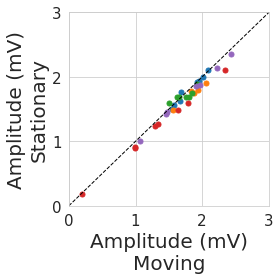

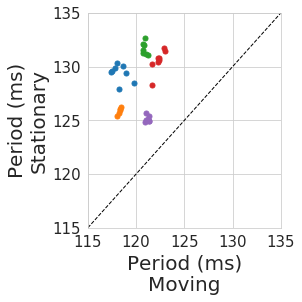

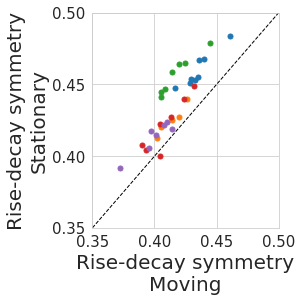

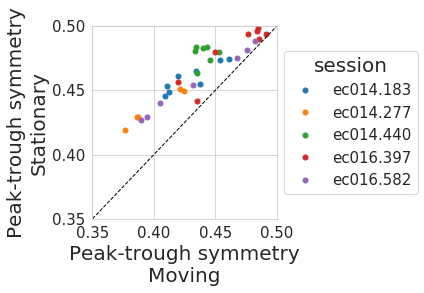

In [8]:
# Customize plotting for each feature
pltfmt = {'lims': {'mv_amp': (0, 3),
                   'ms_period': (115, 135),
                   'time_rdsym': (.35, .5),
                   'time_ptsym': (.35, .5)},
          'ticks': {'mv_amp': np.arange(4),
                   'ms_period': np.arange(115, 140, 5),
                   'time_rdsym': np.arange(.35, .55, .05),
                   'time_ptsym': np.arange(.35, .55, .05)},
          'label': {'mv_amp': 'Amplitude (mV)',
                   'ms_period': 'Period (ms)',
                   'time_rdsym': 'Rise-decay symmetry',
                   'time_ptsym': 'Peak-trough symmetry'},
          'letter': {'mv_amp': 'A',
                     'ms_period': 'B',
                     'time_rdsym': 'C',
                     'time_ptsym': 'D'}
         }

for feat in pltfmt['lims'].keys():
    df_plt = df_beh[['sess', 'sh', feat+'_mean_fast', feat+'_mean_slow']]
    df_plt = df_plt.set_index(['sess', 'sh']).stack().reset_index().rename(columns={'level_2':'speed', 0:'value'})
    df_plt['speed'] = [x[-4:] for x in df_plt['speed']]
    
    if feat == 'time_ptsym':
        figsize = (6, 4)
    elif feat == 'mv_amp':
        figsize = (4, 4)
    elif feat == 'time_rdsym':
        figsize = (4.3, 4.3)
    else:
        figsize = (4.3, 4.3)
    plt.figure(figsize=figsize)
    for sess in df_beh['sess'].unique():
        df_plt = df_beh[df_beh['sess']==sess]
        plt.plot(df_plt[feat+'_mean_fast'], df_plt[feat+'_mean_slow'], '.', label=sess)
    plt.plot([pltfmt['lims'][feat][0], pltfmt['lims'][feat][1]],
             [pltfmt['lims'][feat][0], pltfmt['lims'][feat][1]], 'k--')
    plt.xticks(pltfmt['ticks'][feat])
    plt.yticks(pltfmt['ticks'][feat])
    plt.xlabel(pltfmt['label'][feat] + '\nMoving')
    plt.ylabel(pltfmt['label'][feat] + '\nStationary')
    plt.xlim(pltfmt['lims'][feat])
    plt.ylim(pltfmt['lims'][feat])
    if feat == 'time_ptsym':
        legend = plt.legend(fontsize=15, loc='center left',
                            bbox_to_anchor=(1, 0.5), title='session')
        legend.get_title().set_fontsize('20')
        
    plt.tight_layout()
    plt.savefig('figs/3/{:s}.png'.format(pltfmt['letter'][feat]))
    
    W, p = stats.wilcoxon(df_beh[feat + '_mean_fast'], df_beh[feat + '_mean_slow'])
    print(feat, 'W = {:.0f}, p = {:.1E}'.format(W, p))

# E. GLM coefficients
Speed ~ amp + period + symmetries

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


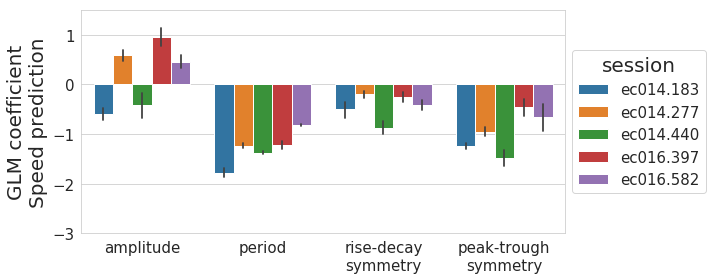

In [9]:
df_plt = df_beh[['sess', 'sh'] + list(df_beh.filter(like='glmcoef').columns)]
df_plt = df_plt.set_index(['sess', 'sh']).stack().reset_index().rename(columns={'level_2':'feature', 0:'coef'})
df_plt['feature'] = [x[:-8] for x in df_plt['feature']]
df_plt.replace({'mv_amp': 'amplitude',
                'ms_period': 'period',
                'time_rdsym': 'rise-decay\nsymmetry',
                'time_ptsym': 'peak-trough\nsymmetry'}, inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='feature', y='coef', hue='sess', data=df_plt,
            order=['amplitude', 'period', 'rise-decay\nsymmetry', 'peak-trough\nsymmetry'])
legend = plt.legend(fontsize=15, loc='center left',
                    bbox_to_anchor=(1, 0.5), title='session')
legend.get_title().set_fontsize('20')
plt.ylabel('GLM coefficient\nSpeed prediction')
plt.xlabel('')
plt.ylim(-3, 1.5)
plt.tight_layout()
plt.savefig('figs/3/E.png')
